In [31]:
import cv2

import numpy as np
import pandas as pd
from joblib import load, dump

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional,
                          TimeDistributed)
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.callbacks import TensorBoard
from keras import optimizers

nPoints = 18

KEYPOINTS = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16]]

POSE_PAIRS_MOD = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [8,11]]

def plotSinglePose(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        
        for pair in POSE_PAIRS:
            # Checking just xcoord for valid point is enough
            valid_pt1 = (posePoint[pair[0]][0] > 0)
            valid_pt2 = (posePoint[pair[1]][0] > 0)
            if valid_pt1 and valid_pt2:
                xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()

def plotSinglePose_mod(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        with plt.style.context('Solarize_Light2'):
            for pair in POSE_PAIRS_MOD:
                # Checking just xcoord for valid point is enough
                valid_pt1 = (posePoint[pair[0]][0] != -1)
                valid_pt2 = (posePoint[pair[1]][0] != -1)
                if valid_pt1 and valid_pt2:
                    xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                    ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                    plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()        
        
def flat_to_pose(flatPose):
    pose_dim = flatPose.reshape((-1, 2))
    
    return {i:pose_dim[i].tolist() for i in range(0, len(pose_dim))}
    

pose_data_file = "../data/frames/forRNN_pose_by_daner.out"
pose_data_by_dancer = load(pose_data_file)

In [86]:
dancers = len(pose_data_by_dancer)
X = []
y = []
seqLen = 8
slide = 1

for dancer in range(dancers):
    pose_coords = pose_data_by_dancer[dancer]
    poses = len(pose_coords)
    if poses<60:
        continue #go to next dancer
    
    for i in range(0, poses - seqLen, slide):
        X.append(pose_coords[i:i+seqLen])
        y.append(pose_coords[i+seqLen])

X = np.array(X).astype(float)
y = np.array(y).astype(float)

In [87]:
print(X.shape)
print(y.shape)

dim = X.shape[2]
for i in range(0, dim):
    if i%2 == 0:
        X[:,:,i] = X[:,:,i]/640.
        y[:,i] = y[:,i]/640.
    else:
        X[:,:,i] = X[:,:,i]/360.
        y[:,i] = y[:,i]/360.

print(X.shape)
print(y.shape)

(34424, 16, 36)
(34424, 36)
(34424, 16, 36)
(34424, 36)


In [105]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='loss', min_delta = 0.001, patience=6, verbose=1)
tb = TensorBoard(histogram_freq=1, write_grads=True)
save_model = ModelCheckpoint("../models/seqL8_6x_weights.{epoch:05d}.hdf5", verbose=1, period=100)

kpoints = 36
drop_prob = 0.2
# Model
print('Build model...')
salsa_model = Sequential()
salsa_model.add(LSTM(6*kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True))
salsa_model.add(Dropout(drop_prob))
#salsa_model.add(LSTM(12*kpoints, activation='relu', return_sequences=True))
salsa_model.add(LSTM(6*kpoints, activation='relu', return_sequences=False))
salsa_model.add(Dropout(drop_prob))
salsa_model.add(Dense(kpoints))
#salsa_model.add(Dense(kpoints))
salsa_model.summary()

adm = optimizers.Adam(lr=0.001)
salsa_model.compile(optimizer=adm, loss='mean_squared_error', metrics=['mse'])
hist = salsa_model.fit(X, y, epochs=1200, verbose=True, callbacks=[save_model])

#optimizer = RMSprop(lr=0.0

Build model...
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 16, 216)           218592    
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 216)           0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 216)               374112    
_________________________________________________________________
dropout_8 (Dropout)          (None, 216)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 36)                7812      
Total params: 600,516
Trainable params: 600,516
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1200
34424/34424 [==============================] - 48s 1ms/step - loss: 0.0162 - mean_squ

34424/34424 [==============================] - 43s 1ms/step - loss: 0.1813 - mean_squared_error: 0.1813
Epoch 130/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0570 - mean_squared_error: 0.0570
Epoch 131/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 132/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 1.1673 - mean_squared_error: 1.1673
Epoch 133/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.6463 - mean_squared_error: 0.6463
Epoch 134/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 135/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 136/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 137/1200
34424/34424 [==============================] - 4

34424/34424 [==============================] - 43s 1ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 266/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 267/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 268/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 269/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 270/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 49.1486 - mean_squared_error: 49.1486
Epoch 271/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 410.5020 - mean_squared_error: 410.5020
Epoch 272/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 18.3819 - mean_squared_error: 18.3819
Epoch 273/1200
34424/34424 [===========================

34424/34424 [==============================] - 43s 1ms/step - loss: 0.0196 - mean_squared_error: 0.0196
Epoch 402/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0196 - mean_squared_error: 0.0196
Epoch 403/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0225 - mean_squared_error: 0.0225
Epoch 404/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0196 - mean_squared_error: 0.0196
Epoch 405/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 406/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 407/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 408/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.2607 - mean_squared_error: 0.2607
Epoch 409/1200
34424/34424 [==============================] - 4

Epoch 470/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 471/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 472/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 473/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 474/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 475/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 476/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 477/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 478/1200
34424/34424 [====================

34424/34424 [==============================] - 46s 1ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 606/1200
34424/34424 [==============================] - 45s 1ms/step - loss: 16.0462 - mean_squared_error: 16.0462
Epoch 607/1200
34424/34424 [==============================] - 46s 1ms/step - loss: 0.0536 - mean_squared_error: 0.0536
Epoch 608/1200
34424/34424 [==============================] - 45s 1ms/step - loss: 0.0538 - mean_squared_error: 0.0538
Epoch 609/1200
34424/34424 [==============================] - 45s 1ms/step - loss: 0.4806 - mean_squared_error: 0.4806
Epoch 610/1200
34424/34424 [==============================] - 44s 1ms/step - loss: 0.4055 - mean_squared_error: 0.4055
Epoch 611/1200
34424/34424 [==============================] - 47s 1ms/step - loss: 0.0300 - mean_squared_error: 0.0300
Epoch 612/1200
34424/34424 [==============================] - 43s 1ms/step - loss: 0.6449 - mean_squared_error: 0.6449
Epoch 613/1200
34424/34424 [==============================] -

KeyboardInterrupt: 

In [82]:
hist = salsa_model.fit(X, y, epochs=20, verbose=True)

Epoch 1/20
34944/34944 [==============================] - 22s 620us/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 2/20
34944/34944 [==============================] - 22s 637us/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 3/20
34944/34944 [==============================] - 23s 669us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/20
34944/34944 [==============================] - 24s 673us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 5/20
34944/34944 [==============================] - 23s 665us/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 6/20
34944/34944 [==============================] - 23s 664us/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 7/20
34944/34944 [==============================] - 23s 663us/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 8/20
34944/34944 [==============================] - 23s 665us/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 9/20
34944/34944 [==============================] - 23s 66

In [85]:
salsa_model.save("../models/twolayerLSTM_relu_36kp_8seql_norm_16iters.h5")

In [46]:
def genSalsa(seedPoses, salsaModel, seqLen, steps = 8):
    seqLen = seedPoses.shape[1]
    for i in range(steps):
        y_pred = salsaModel.predict(seedPoses[:,-(seqLen):,:])
        seedPoses = np.append(seedPoses, [y_pred], axis=1)
    return seedPoses

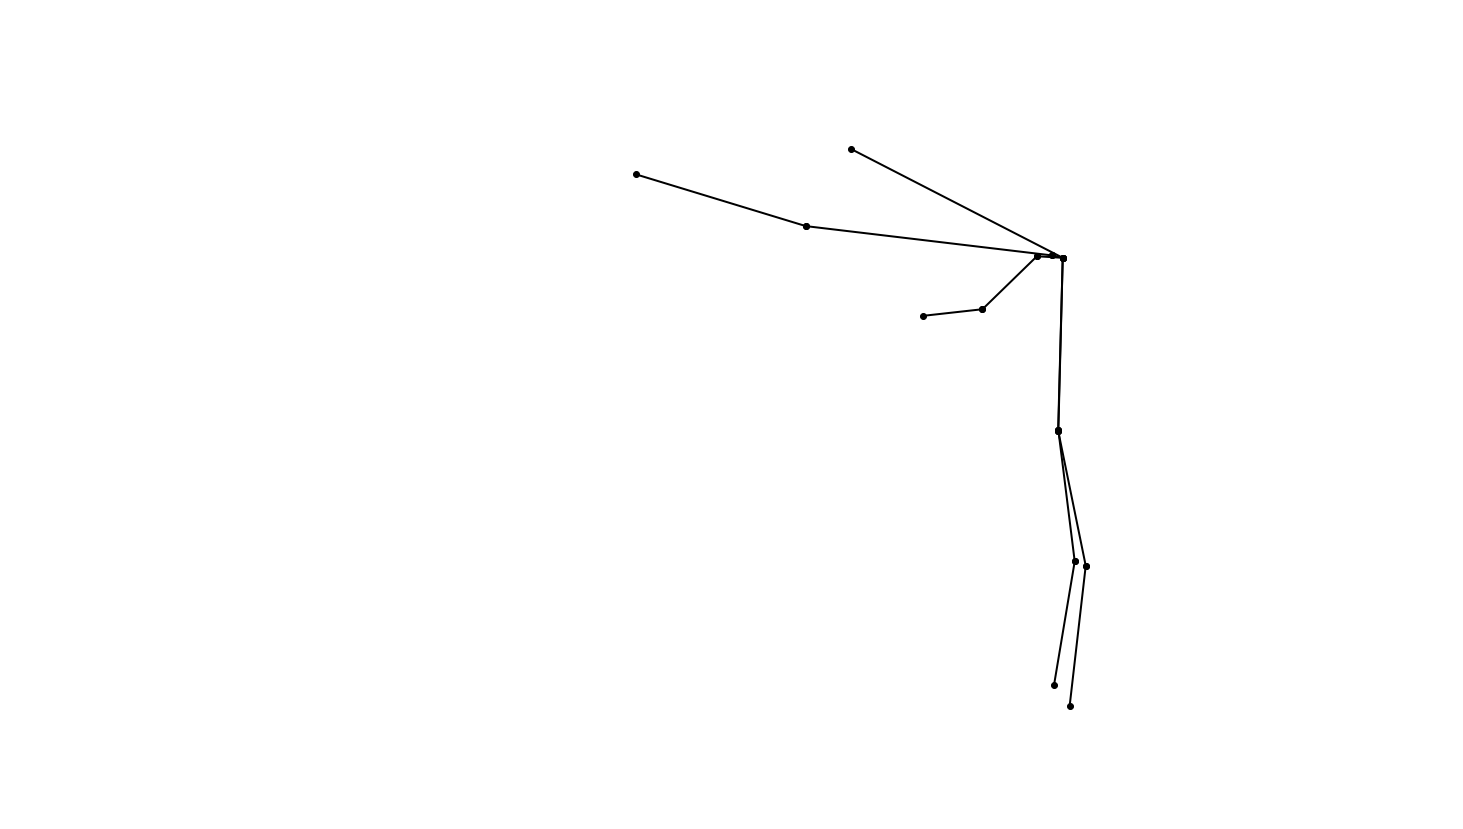

"\nfor i in range(0, 2):    \n    y_test = salsa_model.predict(x)\n    print(x.shape)\n    print(y_test.shape)\n    np.append(x, [y_test], axis = 1)\n    print(x.shape)\n    x = np.delete(x, 0, axis=1)\n    print(x.shape)\n    #plt.rcParams['figure.figsize'] = [30, 15]\n    #plotSinglePose(flat_to_pose(y_test))\n    #time.sleep(60)\n    print(y_test)\n"

In [101]:
#from keras.models import load_model
#salsa_model = load_model("../models/threelayerLSTM.h5")
import time

d = np.random.randint(1, 70)
p = np.random.randint(0, len(pose_data_by_dancer[d]))
x = np.array([pose_data_by_dancer[d][p: p+seqLen]]).astype(float)
for i in range(0, kpoints):
    if i%2 == 0:
        x[:,:,i] = x[:,:,i]/640
    else:
        x[:,:,i] = x[:,:,i]/360

gen_salsa = genSalsa(x, salsa_model, seqLen, 48)

for i in range(0, kpoints):
    if i%2 == 0:
        gen_salsa[:,:,i] = gen_salsa[:,:,i]*640
    else:
        gen_salsa[:,:,i] = gen_salsa[:,:,i]*360


#y_test = salsa_model.predict(x)

#print(x)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose_mod(flat_to_pose(gen_salsa[:,seqLen,:]))

#x = X = np.delete(x, [0, 1, 30, 31, 32, 33, 34, 35], axis=2)
'''
for i in range(0, 2):    
    y_test = salsa_model.predict(x)
    print(x.shape)
    print(y_test.shape)
    np.append(x, [y_test], axis = 1)
    print(x.shape)
    x = np.delete(x, 0, axis=1)
    print(x.shape)
    #plt.rcParams['figure.figsize'] = [30, 15]
    #plotSinglePose(flat_to_pose(y_test))
    #time.sleep(60)
    print(y_test)
'''

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


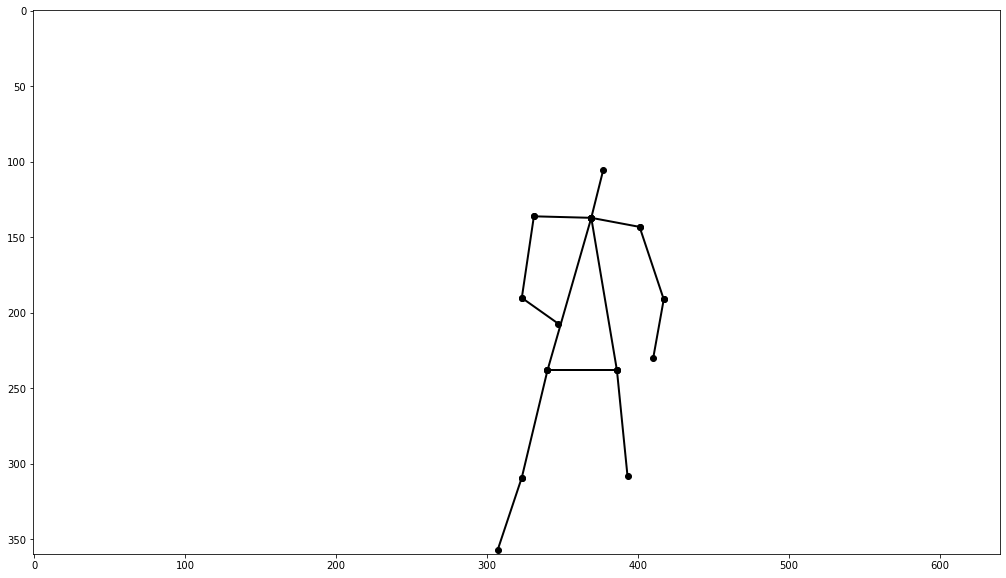

In [102]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

x_for_anim = gen_salsa

plt.rcParams['figure.figsize'] = [20, 10]                              
fig = plt.figure()
ax = plt.axes(xlim=(0, 640), ylim=(0, 360))
                              
def animate(i):
    ax.clear()
    pose = x_for_anim[0][i].reshape((-1, 2))
    #print(pose)
    imgArray = np.ones((360, 640))
    ax.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
    for pair in POSE_PAIRS_MOD:
        # Checking just xcoord for valid point is enough
        valid_pt1 = (pose[pair[0]][0] != -1)
        valid_pt2 = (pose[pair[1]][0] != -1)
        if valid_pt1 and valid_pt2:
            xs = [pose[pair[0]][0], pose[pair[1]][0]]
            ys = [pose[pair[0]][1], pose[pair[1]][1]]
            ax.plot(xs, ys,'ko-', linewidth=2)                         

anim = FuncAnimation(fig, animate, frames=48+seqLen, interval=125)
anim
anim.save('test_16_.gif', writer='imagemagick')

In [51]:
x

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [113]:
salsa_model.weights
#w= salsa_model.get_weights()

[<tf.Variable 'lstm_13/kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_13/recurrent_kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_13/bias:0' shape=(144,) dtype=float32_ref>,
 <tf.Variable 'lstm_14/kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_14/recurrent_kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_14/bias:0' shape=(144,) dtype=float32_ref>,
 <tf.Variable 'lstm_15/kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_15/recurrent_kernel:0' shape=(36, 144) dtype=float32_ref>,
 <tf.Variable 'lstm_15/bias:0' shape=(144,) dtype=float32_ref>,
 <tf.Variable 'dense_5/kernel:0' shape=(36, 36) dtype=float32_ref>,
 <tf.Variable 'dense_5/bias:0' shape=(36,) dtype=float32_ref>]

In [922]:
x = np.delete(x, [0, 1, 32, 33, 34, 35], axis=2)
print(x.shape)

(1, 16, 28)


//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


In [873]:
a = np.ones((1,8, 36))
b = np.ones((1,36))*2
print(a.shape)
a = np.append(a, [b], axis=1)
np.delete(a, 0, axis=1)
print(a)

(1, 8, 36)
[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 

In [148]:
salsa_retrain = load_model("../models/twolayerLSTM.h5")
hist = salsa_retrain.fit(X, y, epochs=30, verbose=True)#, callbacks=[early_stopping])

Epoch 1/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5725 - mean_absolute_error: 53.8623 - acc: 0.0356
Epoch 2/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.6357 - mean_absolute_error: 53.8665 - acc: 0.0356
Epoch 3/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5952 - mean_absolute_error: 53.8773 - acc: 0.0356
Epoch 4/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5500 - mean_absolute_error: 53.8890 - acc: 0.0356
Epoch 5/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.6418 - mean_absolute_error: 53.8604 - acc: 0.0356
Epoch 6/30
16189/16189 [==============================] - 33s 2ms/step - loss: 6713.6420 - mean_absolute_error: 53.8643 - acc: 0.0356
Epoch 7/30
16189/16189 [==============================] - 34s 2ms/step - loss: 6713.5634 - mean_absolute_error: 53.8492 - acc: 0.0356
Epoch 8/30
16189/16189 [==============================] - 34s 

In [149]:
salsa_retrain.save("../models/twolayerLSTM_90Iterms.h5")

[[[300 136 299 ... 129 314 136]
  [276 129 284 ...  -1 293 129]
  [261 113 267 ...  -1 277 120]
  ...
  [308 113 308 ... 113 316 113]
  [306 114 307 ... 113 315 113]
  [306 121 300 ... 120 315 120]]]
[[293.59274 105.33664 314.54388 129.89502 301.70557 128.8758  279.8331
  139.32631 254.00594 130.66652 322.27377 128.92693 313.08234 138.97702
  285.19125 132.39873 307.73447 179.62575 304.30933 217.0111  302.84113
  252.84648 321.38504 179.76369 320.65366 217.1679  318.15872 254.05928
  265.9411   91.47726 266.76755  91.9408  218.38156  75.93291 210.40962
   75.38097]]


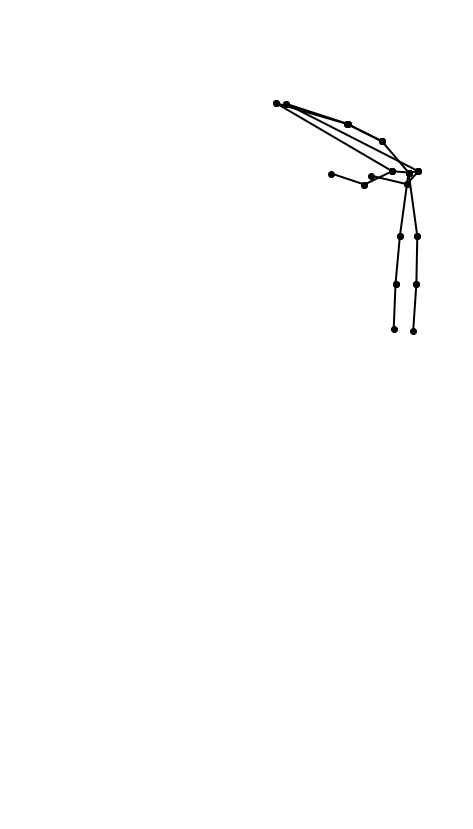

In [191]:
#from keras.models import load_model
#model_to_test = load_model("../models/twolayerLSTM.h5")

p = np.random.randint(0, 600)

x = np.array([pose_data_by_dancer[40][p: p+seqLen]])
#x = x[0:20]*0 
y = salsa_retrain.predict(x)
print(x)
print(y)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose(flat_to_pose(y))

In [167]:
wts = salsa_retrain.get_weights()
salsa_retrain.summary()
(10512-144)/(48*36)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 48, 36)            10512     
_________________________________________________________________
lstm_16 (LSTM)               (None, 36)                10512     
_________________________________________________________________
dense_7 (Dense)              (None, 36)                1332      
Total params: 22,356
Trainable params: 22,356
Non-trainable params: 0
_________________________________________________________________


6.0

In [135]:
from itertools import product

act_funcs = ['relu', 'tanh']
layers = [2, 3]
epochs = range(100, 250, 50)

for item in product(act_funcs, layers, epochs):
    print(item)

    
def salsa_model_template(item):
    """
    item is tuple (activation, no of layers, epochs)
    """
    
    
    
    

('relu', 2, 100)
('relu', 2, 150)
('relu', 2, 200)
('relu', 3, 100)
('relu', 3, 150)
('relu', 3, 200)
('tanh', 2, 100)
('tanh', 2, 150)
('tanh', 2, 200)
('tanh', 3, 100)
('tanh', 3, 150)
('tanh', 3, 200)
